In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
#from sparse_rrt.systems.cartpole import Cartpole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd
from plan_utility.line_line_cc import *
import pickle
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (6, 969), (7, 927)]
# (5,931), (6, 286)
obs_idx = 3

p_idx = 912
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

generated.
(5, 2)


In [2]:
# search for goal
"""
for p_idx in range(900, 1000):
    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
    sgs = pickle.load(sgs)
    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
    if dis[0] >= np.pi:
        dis[0] = 2*np.pi - dis[0]
    if dis[1] >= np.pi:
        dis[1] = 2*np.pi - dis[1]
        
    if np.linalg.norm(dis) <= 1e-1:
        break
print(p_idx)
"""

"\nfor p_idx in range(900, 1000):\n    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')\n    sgs = pickle.load(sgs)\n    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))\n    if dis[0] >= np.pi:\n        dis[0] = 2*np.pi - dis[0]\n    if dis[1] >= np.pi:\n        dis[1] = 2*np.pi - dis[1]\n        \n    if np.linalg.norm(dis) <= 1e-1:\n        break\nprint(p_idx)\n"

In [3]:
# load path
path = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/%d/path_%d.pkl' % (obs_idx, p_idx), 'rb')
path = pickle.load(path)
controls = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/%d/control_%d.pkl' % (obs_idx, p_idx), 'rb')
controls = pickle.load(controls)
costs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
costs = pickle.load(costs)
sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/car_obs/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)

In [4]:
def enforce_bounds(state):
    '''
    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    WIDTH = 2.0
    LENGTH = 1.0

    STATE_X = 0
    STATE_Y = 1

    STATE_THETA = 2 
    MIN_X = -25
    MAX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    
    
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """
    if state[2] < -np.pi:
        new_state[2] += 2*np.pi
    elif state[2] > np.pi:
        new_state[2] -= 2*np.pi
    return new_state



def overlap(b1corner,b1axis,b1orign,b1dx,b1dy,b2corner,b2axis,b2orign,b2dx,b2dy):
    # this only checks overlap of b1 w.r.t. b2
    # a complete check should do in both directions
    b2ds = [b2dx, b2dy]
    for a in range(0,2):
        t=b1corner[0][0]*b2axis[a][0]+b1corner[0][1]*b2axis[a][1] # project corner to the axis by inner product

        tMin = t
        tMax = t
        for c in range(1,4):
            t = b1corner[c][0]*b2axis[a][0]+b1corner[c][1]*b2axis[a][1] # project corner to the axis by inner product
            # find range by [tMin, tMax]
            if t < tMin:
                tMin = t
            elif t > tMax:
                tMax = t
        # since b2 the other corners (corner 1, 2, 3) are larger than b2orign (project of corner 0 to axis)
        # specifically, the range is [b2orign[i], b2orign[i]+size(i)] (of the projected point by dot product)
        # we only need to compare tMax with b2orign[i], and tMin with size(i)+b2orign[i]
        if ((tMin > (b2ds[a] + b2orign[a])) or (tMax < b2orign[a])):
            return False

    return True

def IsInCollision(x, obc, obc_width=4.):
    car_width = 2.0
    car_len = 1.0
    width = 8.0
    WIDTH = car_width
    LENGTH = car_len
    STATE_X = 0
    STATE_Y = 1
    STATE_THETA = 2
    MIN_X = -25
    MAX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    if x[0] < MIN_X or x[0] > MAX_X or x[1] < MIN_Y or x[1] > MAX_Y:
        return True
        
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=np.cos(x[STATE_THETA])*(WIDTH/2.0)
    X1[1]=-np.sin(x[STATE_THETA])*(WIDTH/2.0)
    Y1[0]=np.sin(x[STATE_THETA])*(LENGTH/2.0)
    Y1[1]=np.cos(x[STATE_THETA])*(LENGTH/2.0)

    for j in range(0,2):
        # order: (left-bottom, right-bottom, right-upper, left-upper)
        # assume angle (state_theta) is clockwise
        robot_corner[0][j]=x[j]-X1[j]-Y1[j]
        robot_corner[1][j]=x[j]+X1[j]-Y1[j]
        robot_corner[2][j]=x[j]+X1[j]+Y1[j]
        robot_corner[3][j]=x[j]-X1[j]+Y1[j]

        # axis: horizontal and vertical
        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    #print('robot corners:')
    #print(robot_corner)
    length[0]=np.sqrt(robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1])
    length[1]=np.sqrt(robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1])
    # normalize the axis
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[i])

    # obtain the projection of the left-bottom corner to the axis, to obtain the minimal projection length
    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]
    #print('robot orign:')
    #print(robot_orign)
    for i in range(len(obc)):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        for j in range(0,2):
            # order: (left-bottom, right-bottom, right-upper, left-upper)
            obs_corner[0][j] = obc[i][j]
            obs_corner[1][j] = obc[i][2+j]
            obs_corner[2][j] = obc[i][2*2+j]
            obs_corner[3][j] = obc[i][3*2+j]
            
            # horizontal axis and vertical
            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[0][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[1][j] = obs_corner[1][j] - obs_corner[0][j]

        length2[0]=np.sqrt(obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1])
        length2[1]=np.sqrt(obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1])

        # normalize the axis
        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[i1])

        # obtain the inner product of the left-bottom corner with the axis to obtain the minimal of projection value
        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]  # dot product at 0-th corner
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]
        # do checking in both direction (b1 -> b2, b2 -> b1). If at least one shows not-overlapping, then it is not overlapping
        cf=overlap(robot_corner,robot_axis,robot_orign,car_width,car_len,obs_corner,obs_axis,obs_orign,width,width)
        cf=cf and overlap(obs_corner,obs_axis,obs_orign,width,width,robot_corner,robot_axis,robot_orign,car_width,car_len)
        if cf==True:
            return True
    return False

In [5]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [6]:
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
class CarVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CarVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig = plt.gcf()
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(111)
    def _init(self):
        ax = self.ax1
        ax.clear()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-35, 35)
        # add patches
        state = self.states[0]
        self.car = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.car_direction = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                           linewidth=1.0, edgecolor='yellow')
        self.recs = []
        self.recs.append(self.car)
        self.recs.append(self.car_direction)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car.set_transform(t)
        ax.add_patch(self.car)
        self.car_direction.set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)

        # add goal patch
        state = self.states[-1]
        self.car_goal = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.car_direction_goal = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                           linewidth=1.0, edgecolor='yellow')
        self.recs.append(self.car_goal)
        self.recs.append(self.car_direction_goal)
        
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car_goal.set_transform(t)
        ax.add_patch(self.car_goal)
        self.car_direction_goal.set_transform(t)
        self.car_direction_goal_patch = ax.add_patch(self.car_direction_goal)


        return self.recs
    def _animate(self, i):
        ax = self.ax1
        ax.set_xlim(-25, 25)
        ax.set_ylim(-35, 35)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)

        # modify car_direction
        self.car_direction_patch.remove()
        self.car_direction = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                      linewidth=1.0, edgecolor='yellow')
        self.recs[1] = self.car_direction
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[1].set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)
        
        return self.recs



    def animate(self, states, actions, costs, obstacles, sg, wrap_system):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 8.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            
            
            action = actions[i]
            # number of steps for propagtion
            #num_steps = int(np.round(costs[i]/self.params['integration_step']))
            num_steps = 100000
            for j in range(num_steps):
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system(s, action, self.params['integration_step'])
                assert not IsInCollision(s, obs_i)
                if np.linalg.norm(s - states[i+1]) <= 1e-10:
                    break

            
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        traj_recs = []
        plot_step_sz = 500
        for i in list(range(1,len(traj))) + [0]:
            if i % plot_step_sz == 0:
                # plot the scene change
                if i == 0:
                    car_color = "green"
                    direction_color = "yellow"
                else:
                    car_color = "blue"
                    direction_color = "yellow"
                ax = self.ax1
                ax.set_xlim(-25, 25)
                ax.set_ylim(-35, 35)
                state = traj[i]
                car = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                                       self.params['car_w'],self.params['car_l'],\
                                                      linewidth=.5,edgecolor=car_color,facecolor=car_color)
                car_direction = patches.Arrow(state[0],state[1],\
                                                       self.params['car_w']/2,0,\
                                                       linewidth=1.0, edgecolor=direction_color)
                t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                                -state[2]/np.pi * 180) + ax.transData
                car.set_transform(t)
                ax.add_patch(car)
                car_direction.set_transform(t)
                car_direction_patch = ax.add_patch(car_direction)

                traj_recs.append(car)
                traj_recs.append(car_direction)
                
        ax.add_patch(self.car_goal)
        ax.add_patch(self.car_direction_goal)
            

        
        """
        # for thesis
        fig = plt.figure()
        ax = plt.subplot(121)
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        ax.plot(to_plot_list_x[0], to_plot_list_y[0], alpha=1, c='green')
        ax.plot(to_plot_list_x[-1], to_plot_list_y[-1], alpha=1, c='red')
        
        ax = plt.subplot(122)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='black')
        scat_state = ax.scatter(sg[0][0], sg[0][1], c='green', s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c='red', s=50.0, marker='*')
        """


states:
[[-1.09672042e+01  3.06342669e+01 -6.85018861e-01]
 [-1.04998500e+01  3.10311268e+01 -7.23230179e-01]
 [-1.00571609e+01  3.13534453e+01 -5.34435101e-01]
 [-9.57471350e+00  3.16337229e+01 -5.18040428e-01]
 [-9.34134301e+00  3.17760934e+01 -5.78025838e-01]
 [-8.91407259e+00  3.20063249e+01 -4.09473495e-01]
 [-8.66374298e+00  3.21183556e+01 -4.32396625e-01]
 [-8.06860501e+00  3.23979506e+01 -4.46073951e-01]
 [-7.72738124e+00  3.25739855e+01 -5.06928710e-01]
 [-7.46349782e+00  3.27024611e+01 -3.98614098e-01]
 [-7.06939750e+00  3.28684435e+01 -3.98626516e-01]
 [-6.54598017e+00  3.30520455e+01 -2.75431709e-01]
 [-5.95463513e+00  3.32142193e+01 -2.59814681e-01]
 [-5.59112355e+00  3.32975497e+01 -1.90425379e-01]
 [-5.27336712e+00  3.33534886e+01 -1.57868505e-01]
 [-5.07319090e+00  3.33883919e+01 -1.87769417e-01]
 [-4.58505768e+00  3.34626869e+01 -1.13776687e-01]
 [-4.09763396e+00  3.35164844e+01 -1.06024272e-01]
 [-3.49029248e+00  3.35648020e+01 -5.24829487e-02]
 [-3.26286354e+00  3.35

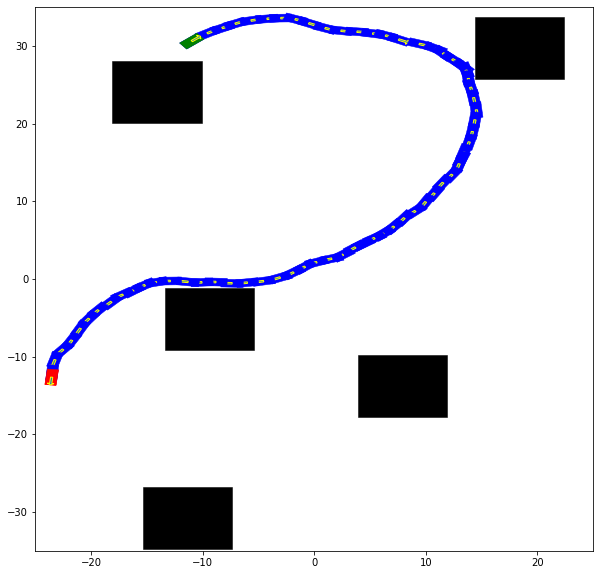

In [7]:
params = {}
car_width = 2.0
car_len = 1.0
width = 8.

params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.002

system = _sst_module.Car()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = CarVisualizer(dynamics, params)
states = path
actions = controls
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
anim = vis.animate(np.array(states), np.array(actions), np.array(costs), obs_list, np.array(sgs), system)
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

In [8]:
print(obs_idx)
print(p_idx)

3
912


(5, 2800, 2)
(14000, 2)


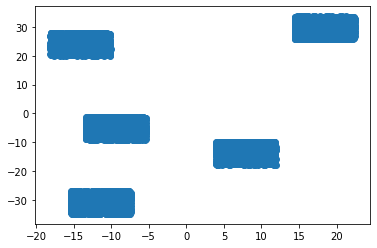

In [9]:
# visualize point cloud
import matplotlib.pyplot as plt
print(obc_list.shape)
obc_all = np.concatenate(obc_list_total[obs_idx], axis=0)
print(obc_all.shape)
plt.scatter(obc_all[:,0], obc_all[:,1])
plt.show()

(14000, 2)


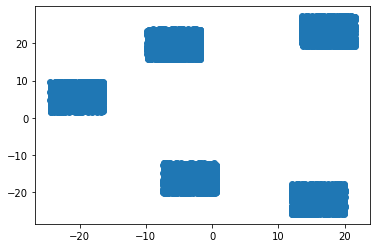

(14000, 2)


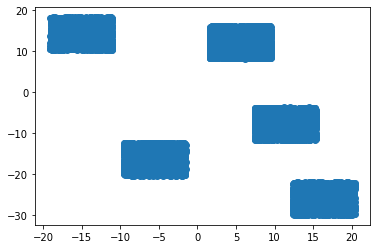

In [10]:
for i in range(2):
    obc_all = np.concatenate(obc_list_total[i], axis=0)
    print(obc_all.shape)
    plt.scatter(obc_all[:,0], obc_all[:,1])
    plt.show()